# MNIST convolutional neural networks

* Make a networks like LeNet5 structure with MNIST data
* input pipeline: `tf.data`
* `Eager execution`

### Import modules

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import layers
tf.enable_eager_execution()

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/multi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Import data

In [3]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_data = train_data.reshape([-1, 28, 28, 1])
train_data = train_data.astype(np.float32)
train_labels = train_labels.astype(np.int32)

test_data = test_data / 255.
test_data = test_data.reshape([-1, 28, 28, 1])
test_data = test_data.astype(np.float32)
test_labels = test_labels.astype(np.int32)

### Show the MNIST

label = 5


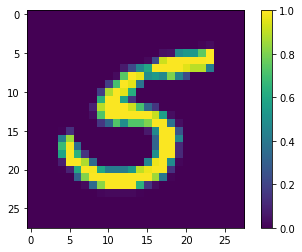

In [4]:
index = 219
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index][...,0])
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### Set up dataset with `tf.data`

#### input pipeline `tf.data.Dataset` and Transformation

In [5]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
#test_dataset = test_dataset.batch(batch_size = len(test_data))
test_dataset = test_dataset.batch(batch_size = 32)
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((?, 28, 28, 1), (?,)), types: (tf.float32, tf.int32)>


### Create the model

* Use `tf.keras.layers`

In [6]:
model = tf.keras.models.Sequential()

model.add(layers.Conv2D(kernel_size=(5,5), filters=32,
                        padding='same', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(kernel_size=(5,5), filters=64,
                       padding='same', activation='relu'))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(10))

# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(kernel_size=(5,5), filters=32)
#     tf.keras.layers.Conv2D(kernel_size=(5,5), filters=64),
#     tf.keras.layers.Dense(1024),
#     tf.keras.layers.Dense(10)
# ])

In [7]:
for images, labels in train_dataset.take(1):
    output = model(images)
    print(output.shape)
    


(32, 10)


In [8]:
# without training, just inference a model in eager execution:
for images, labels in train_dataset.take(1):
  print("Logits: ", model(images[0:3]).shape)

Logits:  (3, 10)


### Define a optimizer

In [9]:
# Train the model
optimizer = tf.train.AdamOptimizer(1e-4)
loss_history = []

### Train a model

In [10]:
total_steps = int( len(train_data) / batch_size * max_epochs)
for (step, (images, labels)) in enumerate(train_dataset.take(total_steps)): # just steps number (iterations), NOT epochs
  start_time = time.time()
  with tf.GradientTape() as tape:
    logits = model(images, training=True)
    loss_value = tf.losses.sparse_softmax_cross_entropy(labels, logits)

  loss_history.append(loss_value.numpy())
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  
  if step % 100 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * step / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs, step, loss_value, examples_per_sec, duration))
    
print("training done!")

epochs: 0.96, step: 1800, loss: 0.0463947, (451.25 examples/sec; 0.071 sec/batch)
training done!


### Plot the loss funtion

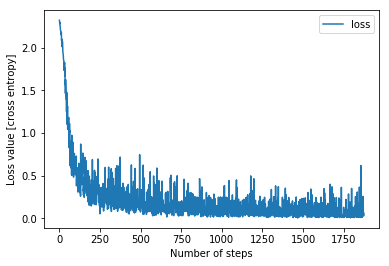

In [11]:
plt.plot(loss_history, label='loss')
plt.xlabel('Number of steps')
plt.ylabel('Loss value [cross entropy]')
plt.legend()
plt.show()

### Test trained model

* test accuracy: 0.9798 for 1 epochs

In [12]:
accuracy = tf.contrib.eager.metrics.Accuracy()

for (step, (images, labels)) in enumerate(test_dataset.take(1)):
  logits = model(images, training=False)
  accuracy(labels=labels, predictions=tf.cast(tf.argmax(logits, 1), tf.int32))
  
print("test accuracy: {}".format(accuracy.result()))

test accuracy: 0.96875


### Plot test set

In [13]:
np.random.seed(219)

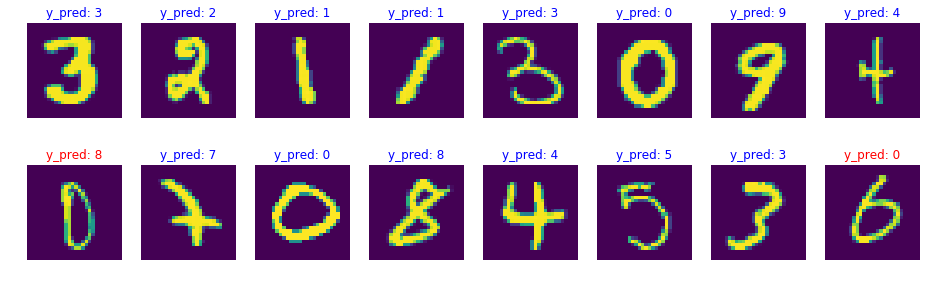

In [14]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred_ = model(batch_xs, training=False)

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred_)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  p.imshow(px.reshape(28, 28))
  p.axis('off')